In [2]:
import sqlite3
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import joblib
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt


In [3]:
def generate_features(df, N=5):
    stat_cols = [
        "fgm_home", "fga_home", "fg_pct_home", "fg3m_home", "fg3a_home", "fg3_pct_home",
        "ftm_home", "fta_home", "ft_pct_home", "oreb_home", "dreb_home", "reb_home", "ast_home",
        "stl_home", "blk_home", "tov_home", "pf_home", "pts_home", "plus_minus_home"
    ]
    stat_cols_away = [c.replace("_home", "_away") for c in stat_cols]

    def add_rolling_feats(df, stat_cols, team_col, prefix, wl_col):
        df = df.sort_values(["game_date"])
        for stat in stat_cols:
            if stat not in df.columns:
                continue
            df[f"{prefix}_last{N}_{stat}_mean"] = (
                df.groupby(team_col)[stat]
                .transform(lambda x: x.rolling(N, min_periods=1).mean())
            )
        if wl_col in df.columns:
            df[f"{prefix}_last{N}_win_rate"] = (
                df.groupby(team_col)[wl_col].transform(lambda x: x.rolling(N, min_periods=1).mean())
            )
        return df

    df["home_win_raw"] = (df["wl_home"] == "W").astype(int)
    df["away_win_raw"] = (df["wl_away"] == "W").astype(int)
    df = add_rolling_feats(df, stat_cols, "team_id_home", "home", "home_win_raw")
    df = add_rolling_feats(df, stat_cols_away, "team_id_away", "away", "away_win_raw")

    for stat in stat_cols:
        away_stat = stat.replace("_home", "_away")
        home_col = f"home_last{N}_{stat}_mean"
        away_col = f"away_last{N}_{away_stat}_mean"
        if home_col in df.columns and away_col in df.columns:
            df[f"last{N}_{stat.replace('_home','')}_diff"] = df[home_col] - df[away_col]

    if "home_last5_win_rate" in df.columns and "away_last5_win_rate" in df.columns:
        df["last5_win_rate_diff"] = df["home_last5_win_rate"] - df["away_last5_win_rate"]

    for col in df.columns:
        if ("qtr" in col or "pts" in col or "mean" in col or "diff" in col or "momentum" in col) and (df[col].dtype == "O"):
            df[col] = pd.to_numeric(df[col], errors="coerce")

    if ("pts_qtr1_home" in df.columns) and ("pts_qtr1_away" in df.columns):
        df["qtr1_diff"] = df["pts_qtr1_home"] - df["pts_qtr1_away"]
    if ("pts_qtr4_home" in df.columns) and ("pts_qtr4_away" in df.columns):
        df["qtr4_diff"] = df["pts_qtr4_home"] - df["pts_qtr4_away"]
    if ("qtr1_diff" in df.columns) and ("qtr4_diff" in df.columns):
        df["qtr4_momentum"] = df["qtr4_diff"] - df["qtr1_diff"]
    ot_cols = [f"pts_ot{i}_home" for i in range(1, 11) if f"pts_ot{i}_home" in df.columns]
    df["is_overtime"] = df[ot_cols].notnull().any(axis=1).astype(int) if ot_cols else 0

    if "pts_home" in df.columns and "pts_away" in df.columns:
        df["home_last5_pts_scored"] = df.groupby("team_id_home")["pts_home"].transform(lambda x: x.rolling(N, min_periods=1).mean())
        df["home_last5_pts_allowed"] = df.groupby("team_id_home")["pts_away"].transform(lambda x: x.rolling(N, min_periods=1).mean())
        df["away_last5_pts_scored"] = df.groupby("team_id_away")["pts_away"].transform(lambda x: x.rolling(N, min_periods=1).mean())
        df["away_last5_pts_allowed"] = df.groupby("team_id_away")["pts_home"].transform(lambda x: x.rolling(N, min_periods=1).mean())
        df["last5_pts_scored_diff"] = df["home_last5_pts_scored"] - df["away_last5_pts_scored"]

    return df


In [4]:
data_path = r"C:\Users\BatuhanÇağlar\Desktop\470\proje\data\basketball\nba.sqlite"
conn = sqlite3.connect(data_path)

table_names = ["game", "line_score", "other_stats"]
dfs = {}
for tname in table_names:
    dfs[tname] = pd.read_sql(f"SELECT * FROM {tname}", conn)

df = dfs['game'].merge(dfs['line_score'], on='game_id', how='left')
df = df.merge(dfs['other_stats'], on='game_id', how='left')

df["game_date"] = pd.to_datetime(df["game_date"])

missing_ratio = df.isnull().mean()
drop_cols = missing_ratio[missing_ratio > 0.7].index.tolist()
for col in df.columns:
    if col in drop_cols:
        continue
    if df[col].isnull().any():
        if pd.api.types.is_numeric_dtype(df[col]):
            df[col] = df[col].fillna(df[col].mean())
        else:
            df[col] = df[col].fillna(df[col].mode()[0])
df = df.drop(columns=drop_cols)
df['home_win'] = (df['wl_home'] == 'W').astype(int)
df = generate_features(df)


In [5]:
feature_cols = [c for c in df.columns if ("last" in c or "diff" in c or "mean" in c or "momentum" in c)]
X = df[feature_cols]
y = df['home_win']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = joblib.load(r"C:\Users\BatuhanÇağlar\Desktop\470\proje\models\basketball_scaler.pkl")
X_test_scaled = scaler.transform(X_test)

model = joblib.load(r"C:\Users\BatuhanÇağlar\Desktop\470\proje\models\basketball_rf.pkl")
model_xgb = joblib.load(r"C:\Users\BatuhanÇağlar\Desktop\470\proje\models\basketball_xgb.pkl")
model_mlp = joblib.load(r"C:\Users\BatuhanÇağlar\Desktop\470\proje\models\basketball_mlp.pkl")



Accuracy: 0.7534943786083257
F1-score: 0.8099115458965498
Confusion matrix:
 [[3006 2016]
 [1229 6913]]
              precision    recall  f1-score   support

           0       0.71      0.60      0.65      5022
           1       0.77      0.85      0.81      8142

    accuracy                           0.75     13164
   macro avg       0.74      0.72      0.73     13164
weighted avg       0.75      0.75      0.75     13164



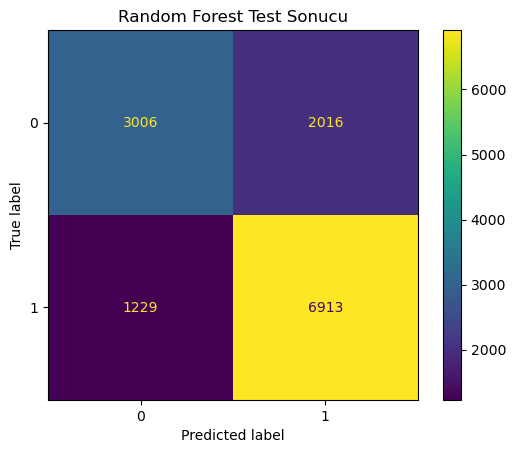

In [6]:
y_pred = model.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Random Forest Test Sonucu")
plt.show()

results = pd.DataFrame({
    "y_true": y_test,
    "y_pred": y_pred
})
results.to_csv("basketball_rf_test_results.csv", index=False)


Accuracy: 0.7556213916742631
F1-score: 0.8109315310020571
Confusion matrix:
 [[3048 1974]
 [1243 6899]]
              precision    recall  f1-score   support

           0       0.71      0.61      0.65      5022
           1       0.78      0.85      0.81      8142

    accuracy                           0.76     13164
   macro avg       0.74      0.73      0.73     13164
weighted avg       0.75      0.76      0.75     13164



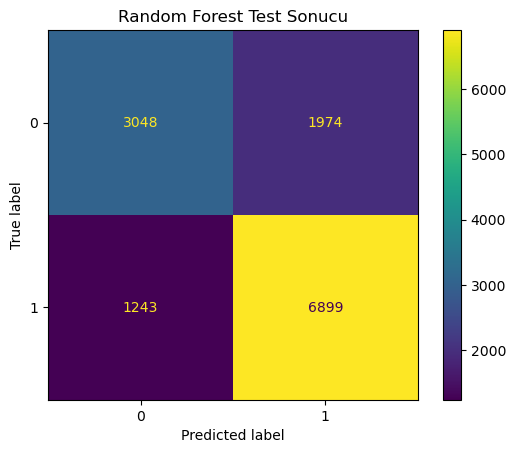

In [7]:
y_pred = model_xgb.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Random Forest Test Sonucu")
plt.show()

results = pd.DataFrame({
    "y_true": y_test,
    "y_pred": y_pred
})
results.to_csv("basketball_rf_test_results.csv", index=False)

Accuracy: 0.7449863263445761
F1-score: 0.8038104143533401
Confusion matrix:
 [[2930 2092]
 [1265 6877]]
              precision    recall  f1-score   support

           0       0.70      0.58      0.64      5022
           1       0.77      0.84      0.80      8142

    accuracy                           0.74     13164
   macro avg       0.73      0.71      0.72     13164
weighted avg       0.74      0.74      0.74     13164



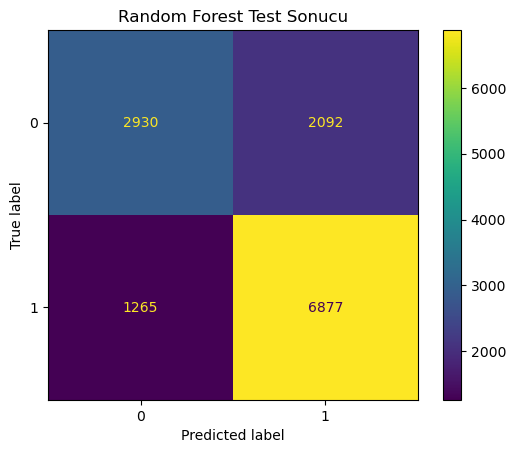

In [8]:
y_pred = model_mlp.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Random Forest Test Sonucu")
plt.show()

results = pd.DataFrame({
    "y_true": y_test,
    "y_pred": y_pred
})
results.to_csv("basketball_rf_test_results.csv", index=False)

Model, basketbol maçlarının galibini yaklaşık %75 doğrulukla ve dengeli bir F1 skoru ile tahmin edebiliyor. F1 skorunun yüksekliği, modelin hem “ev sahibi kazanır” hem de “deplasman kazanır” sınıflarını dengeli şekilde ayırt ettiğini gösterir.

Model özellikle “ev sahibi kazanır” (1) etiketini doğru tahmin etmede daha başarılı %85,
“ev sahibi kaybeder” (0) sınıfında ise doğruluk biraz daha düşük %60